# 1. Import Libraries & Load data file

Import all the necessary libraries which will be used in this project.

Load the data file containing research papers into a dataframe called 'dataset'.


In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import sklearn as sklearn_lda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('ro2').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
dataset = pd.DataFrame.from_records(rows)
dataset

,0,1,2,3,4,5
0,Title,Abstract,Year,Astronomical influence,DOI,Remarks
1,More confounders at global and decadal scales ...,The residuals of 27 globally distributed long ...,2015,Lunar,10.1515/jogs-2015-0020,Tides
2,Plasticity in lunar timing of larval release o...,The environmental conditions in shallow marine...,2017,Lunar,10.3354/meps12071,lunar periodicity of larval release
3,Impacts of artificial light on food intake in ...,Artificial light at night (ALAN) is a major fo...,2020,Lunar,10.1038/s41598-020-63503-9,moon phase on food availability
4,Supermoon Drives Beach Morphological Changes i...,"The effect of the supermoon, which appears muc...",2020,Lunar,10.1029/2020gl089745,Supermoon
...,...,...,...,...,...,...
473,The evidence for and against astronomical impa...,Numerous studies over the past 30 years have s...,2009,"solar, planetary, stellar & galactic",10.1017/s147355040999005x,
474,Simulations of solar and lunar tidal variabili...,Whole Atmosphere Community Climate Model (WACC...,2012,"solar & planetary, lunar",10.1029/2012ja017858,
475,Macro-Scale Patterns in Upwelling/Downwelling ...,The seasonal and interannual variability of ve...,2016,"solar & planetary, lunar",10.1371/journal.pone.0166962,
476,Revisiting the Modulations of Ionospheric Sola...,"In this study, Global Ionosphere Specification...",2019,"solar & planetary, lunar",10.1029/2019sw002184,


# 2. Clean Data

I dropped the unnecessary columns like 'Year', 'Astronomical influence', 'DOI', 'Remarks', and focused solely on the 'Abstract' columns of each paper entry. For papers with no abstracts, I filled the empty cell with the text "No abstract". Next, I name the column 'Abstract' to form a new column called 'PaperText'.

In [ ]:
#rename columns
dataset.columns = (['Title', 'Abstract', 'Year', 'Astronomical influence', 'DOI', 'Remarks'])

#remove unnecessary row
dataset = dataset.drop([0])

#Remove the unecessary columns
dataset = dataset.drop(columns=['Year', 'Astronomical influence', 'DOI', 'Remarks'], axis=1)

#Fill in the empty cells
dataset = dataset.fillna('No conclusion')

#Merge abstract and conclusion
dataset['Paper_Text'] = dataset["Title"] + dataset["Abstract"]

#show first 5 records
dataset.head()

,Title,Abstract,Paper_Text
1,More confounders at global and decadal scales ...,The residuals of 27 globally distributed long ...,More confounders at global and decadal scales ...
2,Plasticity in lunar timing of larval release o...,The environmental conditions in shallow marine...,Plasticity in lunar timing of larval release o...
3,Impacts of artificial light on food intake in ...,Artificial light at night (ALAN) is a major fo...,Impacts of artificial light on food intake in ...
4,Supermoon Drives Beach Morphological Changes i...,"The effect of the supermoon, which appears muc...",Supermoon Drives Beach Morphological Changes i...
5,Effects of thermal conditioning on the perform...,Ocean warming induced by climate change is the...,Effects of thermal conditioning on the perform...


# 3. Preprocess Data

Tokenize each sentence into a list of words, remove punctuations, remove stopwords and words of length less than 3, and then lemmatize.

In [ ]:
#function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# tokenization
tokenized_data = dataset['Paper_Text'].apply(lambda x: x.split())

# Remove punctuation
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\\!?]', '', item) for item in x])
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[.]', ' ', item) for item in x])

#turn to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

#lemmatize by calling lemmatization function
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])

# remove stop-words and words of length less than 2
stop_words = stopwords.words('english')
stop_words.extend(
    ['is', 'on', 'the', 'with', 'or', 'for', 'increase', 'change', 'result',
     'using', 'show', 'observe', 'observation',	'hypothesis',	'times', 'analysis',
     'days',	'index', 	'profile',  'variability', 'effects', 'bias', 'error',
     'level',	'global',	'similar',	'transient', 'decrease',	'assessment',
     'establish',	'event', 'distribution',	'model',	'spectrum',	'estimate',
     'evidence',	'year',	'data',	'exposure',	'phase'	,'demonstrate',	'energy',
     'measurement',	'spectrum',	'inheritance', 'involve', 'particle',	'profile',
     'particle',	'study',	'concentration',	'affect',	'response', 'influence',	'measure',
     'numbers',	'global',	'modulation',	'attribute',	'contribution',	'degree',	'shape',
     'inheritance',	'predict',	'review',	'develop', 'series',	'potential',	'warm',
     'examine',	'evidence',	'deep',	'support',	'use',	'remain',	'dating',
     'use',	'shielding',	'average',	'possible',	'peak',	'thinning',	'similar',
     'silicon',	'measure', 'contribute',	'years',	'2009', 'record', 'significant',
     'little',	'imply',	'variation',	'cold',	'associate',	'retreat', 'values',
     'result',	'outside',	'observation',	'propose',	'index',	'addition',	'present',
     'conditions',	'numerous',	'detector',	'correlation',	'past', 'difference',
     'middle',	'suggest', 'strong',	'include',	'continue', 'trend', 'new',
     'role',	'nucleus',	'disturbance',	'linear',	'temporal',	'place',
     'provide', 'may', 'due', 'different', 'compare', 'occur'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>2])

# 4. Create Bigram and Trigram
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our corpus are: ‘visually_impaired’, ‘programming_language’, ‘block_based_programming’, 'programming environment' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=10, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_data[100]]])

['reconstruction', 'solar', 'spectral_irradiance', 'since', 'maunder', 'minimumsolar', 'irradiance', 'main', 'external', 'driver', "earth's", 'climate ', 'whereas', 'total_solar', 'irradiance', 'main', 'source', 'input', 'climate', 'system', 'solar_irradiance', 'exert', 'control', 'chemical', 'physical_process', "earth's", 'upper_atmosphere ', 'time', 'accurate', 'irradiance', 'however', 'relatively', 'short', 'limit', 'solar', 'climate_change ', 'reconstruct', 'solar', 'total', 'spectral_irradiance', 'range', '115160000', 'since', '1610 ', 'evolution', 'solar', 'photospheric', 'magnetic_flux', 'central', 'input', 'appraise', 'historical', 'sunspot_number', 'simple', 'consistent', 'physical', 'model ', '1 25', 'w/m2', '0 09%', '11year', 'solar', 'total', 'irradiance', 'since', 'maunder', 'minimum ', 'also', 'irradiance', 'individual', 'spectral', 'interval', 'generally', 'four', 'century', 'magnitude', 'higher', 'toward', 'short', 'wavelengths ', 'particular', '11year', 'lyalpha', 'irr

In [ ]:
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [ ]:
# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [ ]:
# de-tokenization, combine tokens together
detokenized_data = []
for i in range(len(dataset)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)

dataset['clean_text']= detokenized_data
documents = dataset['clean_text']

# 5. Perform Exploratory Analysis
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

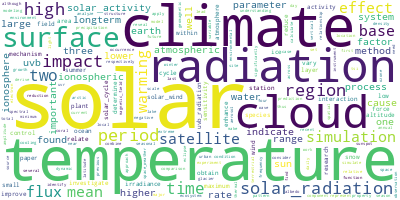

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(documents.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import pandas as pd

# Assuming 'documents' is your pandas Series
word_counts = documents.str.split().apply(len)

# Print the word counts for each element in the Series
print(word_counts)

1       79
2      133
3      124
4       81
5      156
      ... 
473    141
474    154
475    128
476    171
477     96
Name: clean_text, Length: 477, dtype: int64


In [ ]:
total_word_count = word_counts.sum()
print("Total word count:", total_word_count)

Total word count: 59842


# 6. Update preprocess data such as adding or removing stopwords. then run again until step 5

# 7. Create Document-Term Matrix
This is the first step towards topic modeling. We need to represent each and every term and document as a vector.We will use sklearn's TfidfVectorizer to create a document-term matrix using only 3000 terms (words) from our corpus.

In [ ]:
#Set variable number of terms
no_terms = 3000

# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.6, min_df=3, max_features=no_terms, stop_words='english')
# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)

#get features
feature_names = vectorizer.get_feature_names_out()


# 8. Apply Topic Model

We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn's NMF to perform the task of matrix decomposition. The number of topics can be specified by using the n_components parameter.

In [ ]:
#Set variables umber of topics and top words.
no_topics = 10
no_top_words = 15

# Function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model Result:")
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

from sklearn.decomposition import NMF

# Example NMF model
nmf_model = NMF(n_components=no_topics, random_state=42)  # You might have a different number of components
nmf_model.fit(document_matrix)  # Fit your model on the document-term matrix

#display topics for nmf model
display_topic(nmf_model, feature_names, no_topics, no_top_words, 'NMF_Model_Result')


Model Result:


,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,glacier,ssw,ocean,solar,cloud,solar_wind,coral,eclipse,uvb,ionospheric
1,surface,tidal,lake,sunspot,satellite,magnetosphere,reef,solar_eclipse,uvb_radiation,ionosphere
2,solar_radiation,semidiurnal,radiation,tsi,surface,electron,temperature,temperature,plant,tec
3,melt,sw2,uvr,irradiance,cod,space_weather,thermal,totality,species,solar_activity
4,snow,tide,uva,earth,radiative,magnetic_field,bleach,total_solar,growth,occurrence
5,ice,enhancement,climate,climate,stratocumulus,magnetospheric,stress,july,ozone,gnss
6,temperature,ionosphere,nutrient,longterm,ice,wave,coral_reef,gps,radiation,gps
7,radiation,altitude,phytoplankton,solar_cycle,feedback,plasma,sst,path,moss,total_electron_content_tec
8,urban,solar,ecosystem,solar_activity,radiation,structure,mortality,cooling,community,solar_minimum
9,flux,simulation,impact,sun,albedo,flux,species,formosat3,aquatic,stations


Topic titles obtained manually

1. "Glacial Meltdown and Solar Radiation"
2. "Tides and Ionospheric Changes"
3. "UVR Impact on Climate"
4. "Solar Activity and Earth's Climate"
5. "Cloud Albedo in the Arctic"
6. "Solar Wind and Space Weather"
7. "Coral Reef Health and Temperature"
8. "Solar Eclipse and Atmospheric Cooling"
9. "UVB Radiation Effects on Plant Life"
10. "Ionospheric Trends and Solar Activity"

These titles are designed to capture the key themes and topics associated with the word lists provided for each topic.

## Producing inter-topic distance network graph map

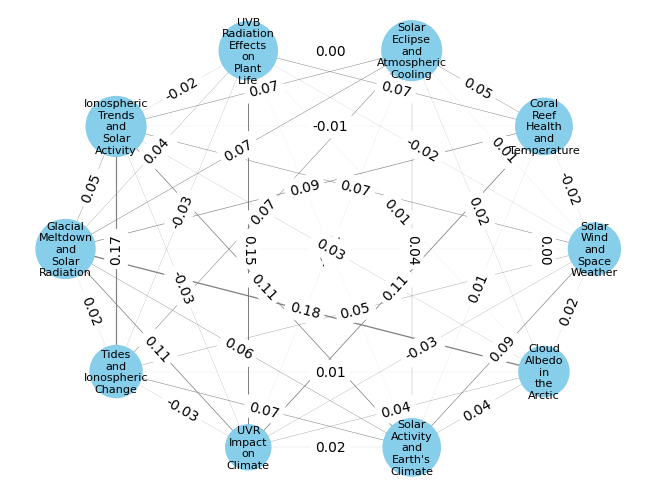

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Titles for each topic
topic_titles = [
    "Glacial Meltdown and Solar Radiation",
    "Tides and Ionospheric Change",
    "UVR Impact on Climate",
    "Solar Activity and Earth's Climate",
    "Cloud Albedo in the Arctic",
    "Solar Wind and Space Weather",
    "Coral Reef Health and Temperature",
    "Solar Eclipse and Atmospheric Cooling",
    "UVB Radiation Effects on Plant Life",
    "Ionospheric Trends and Solar Activity",
]

# Get the topic-term matrix
topic_term_matrix = nmf_model.components_

# Calculate the correlation between topics
topic_similarity = np.corrcoef(topic_term_matrix)

# Create a network graph
G = nx.Graph()

# Add nodes to the graph (topics) with titles as attributes
num_topics = topic_similarity.shape[0]
topics = range(num_topics)
G.add_nodes_from(topics)
for i, title in enumerate(topic_titles):
    G.nodes[i]['title'] = title

# Add weighted edges to the graph based on the correlation matrix
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        correlation_strength = topic_similarity[i, j]
        G.add_edge(i, j, weight=correlation_strength)

node_sizes = [len(G.nodes[node]['title']) * 50 for node in G.nodes()]

# Add weighted edges to the graph based on the correlation matrix
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        correlation_strength = topic_similarity[i, j]
        G.add_edge(i, j, weight=correlation_strength)

# Define edge widths based on correlation strength
edge_widths = [d['weight'] * 5 for i, j, d in G.edges(data=True)]

# Draw the graph with node labels
pos = nx.shell_layout(G)  # You can try different layout algorithms
edge_labels = {(i, j): f"{d['weight']:.2f}" for i, j, d in G.edges(data=True)}
node_labels = {node: G.nodes[node]['title'] for node in G.nodes()}

node_labels = {node: "\n".join(G.nodes[node]['title'].split()) for node in G.nodes()}

nx.draw(
    G,
    pos,
    with_labels=True,
    labels=node_labels,  # Use titles as labels
    font_size=8,
    node_size=node_sizes,
    node_color='skyblue',
    edge_color='gray',
    width=edge_widths,
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the graph
plt.show()

In [ ]:

def display_topic(model, feature_names, no_topics, no_top_words, model_name, topic_index):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx == topic_index:
            print(f"{model_name} Topic #{topic_idx + 1}:")
            print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
display_topic(nmf_model, feature_names, no_topics, no_top_words, 'NMF_Model_Result', topic_index=8)

NMF_Model_Result Topic #9:
uvb uvb_radiation plant species growth ozone radiation moss community aquatic physiological plants pollen compound enhance


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 9. Analyzing our NMF model

To analyze the model, we visualize the topics for interpretability. To calculate the inter-topic distance matrix, you'll generally need the representation of topics in a multidimensional space. You can use the topic-term matrix obtained from the NMF model to understand the relationships between topics.

Here's a basic outline of the process:

1. Extract the topic-term matrix: The matrix obtained from the NMF model represents the topics in terms of their word distributions.

2. Calculate distances/similarities between topics: Use a similarity measure (e.g., cosine similarity, Euclidean distance) on the topic-term matrix to compute the distance/similarity between topics.

3. Create the distance matrix: Compute the distance/similarity values between each topic and construct a matrix where each cell represents the similarity/distance between two topics.

4. Visualize the inter-topic distance matrix: Once you have the topic-topic distance matrix, you can plot a heatmap using libraries like Seaborn or Matplotlib in Python.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming nmf_model is your trained NMF model
topic_similarity = cosine_similarity(nmf_model.components_)

In [ ]:
topic_similarity

array([[1.        , 0.1251745 , 0.2549941 , 0.21408275, 0.28053054,
        0.16566648, 0.18647603, 0.14374792, 0.13571118, 0.18694383],
       [0.1251745 , 1.        , 0.08516349, 0.17368056, 0.08878978,
        0.14488262, 0.07191563, 0.12286797, 0.04040384, 0.24547488],
       [0.2549941 , 0.08516349, 1.        , 0.17802463, 0.15704835,
        0.12517222, 0.20641924, 0.07067313, 0.22901673, 0.11291669],
       [0.21408275, 0.17368056, 0.17802463, 1.        , 0.15118576,
        0.23402104, 0.11605688, 0.11587851, 0.10562147, 0.22838026],
       [0.28053054, 0.08878978, 0.15704835, 0.15118576, 1.        ,
        0.12586716, 0.07819184, 0.07780887, 0.07957376, 0.12248006],
       [0.16566648, 0.14488262, 0.12517222, 0.23402104, 0.12586716,
        1.        , 0.08432397, 0.08337555, 0.07797545, 0.19188994],
       [0.18647603, 0.07191563, 0.20641924, 0.11605688, 0.07819184,
        0.08432397, 1.        , 0.10274883, 0.12598068, 0.08155778],
       [0.14374792, 0.12286797, 0.0706731

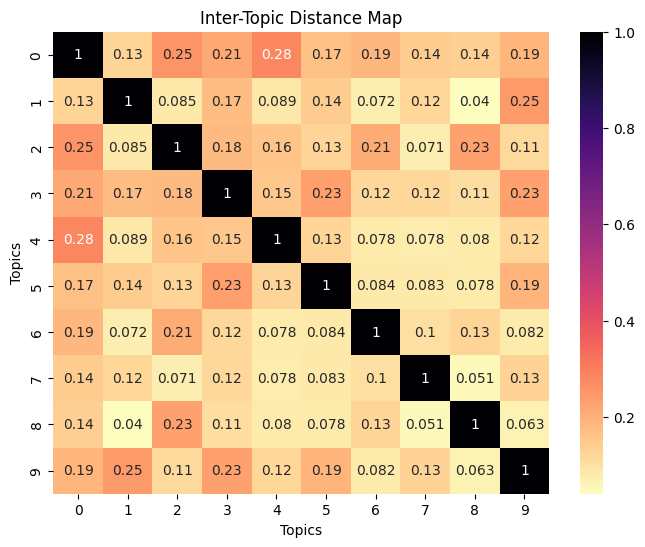

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for topic similarity
plt.figure(figsize=(8, 6))
sns.heatmap(topic_similarity, annot=True, cmap='magma_r', xticklabels=True, yticklabels=True)
plt.title('Inter-Topic Distance Map')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.show()

#'viridis', 'plasma', 'inferno' ,'magma', 'cividis', 'twilight', 'twilight_shifted', 'seismic', 'RdBu', 'tab10'